In [27]:
# EEG Data Checker - Using MNE with BrainAccess data
# Following BrainAccess documentation: https://www.brainaccess.ai/documentation/python-api/3.6.0/usage.html

import mne
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Use inline backend (interactive Qt not available)
%matplotlib inline

# Reload utils module to get updated preprocessing
import importlib
import utils
importlib.reload(utils)
from utils import preprocess_data

FILE_TO_CHECK = "/home/grzegina/documents/projects/EEG2Text-Experiment/data/8/8_full_experiment_20260131_234634.fif"

# Load raw data first to inspect it
raw = mne.io.read_raw_fif(FILE_TO_CHECK, preload=True, verbose=False)
print("=== Raw Data Info ===")
print(raw.info)
print(f"\nDuration: {raw.times[-1]:.1f} seconds")
print(f"Channels: {len(raw.ch_names)}")
print(f"Sample rate: {raw.info['sfreq']} Hz")

=== Raw Data Info ===
<Info | 10 non-empty values
 bads: []
 ch_names: P8, O2, P4, C4, F8, F4, Oz, Cz, Fz, Pz, F3, O1, P7, C3, P3, F7, ...
 chs: 32 EEG, 3 misc, 1 System status channel information (Triux systems)
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 36
 projs: []
 sfreq: 250.0 Hz
>

Duration: 62.9 seconds
Channels: 36
Sample rate: 250.0 Hz


/tmp/ipykernel_9141/3071126905.py:21: RuntimeWarning: This filename (/home/grzegina/documents/projects/EEG2Text-Experiment/data/8/8_full_experiment_20260131_234634.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(FILE_TO_CHECK, preload=True, verbose=False)


In [15]:
# Check the actual data values and units
eeg_data = raw.copy().pick('eeg').get_data()
print("=== Data Statistics (before any processing) ===")
print(f"Shape: {eeg_data.shape} (channels x samples)")
print(f"Data range: {eeg_data.min():.6f} to {eeg_data.max():.6f}")
print(f"Mean: {eeg_data.mean():.6f}")
print(f"Std: {eeg_data.std():.6f}")

# Check if data is in volts or microvolts
# MNE expects data in Volts. Typical EEG is 10-100 µV = 10e-6 to 100e-6 V
if eeg_data.max() > 1:
    print("\n⚠️  Data appears to be in MICROVOLTS (values > 1)")
    print("   This is likely raw ADC values or µV - MNE expects Volts")
else:
    print("\n✓ Data appears to be in VOLTS (values < 1)")

=== Data Statistics (before any processing) ===
Shape: (32, 12901) (channels x samples)
Data range: 3581.688232 to 84555.304688
Mean: 16823.202738
Std: 4628.030060

⚠️  Data appears to be in MICROVOLTS (values > 1)
   This is likely raw ADC values or µV - MNE expects Volts


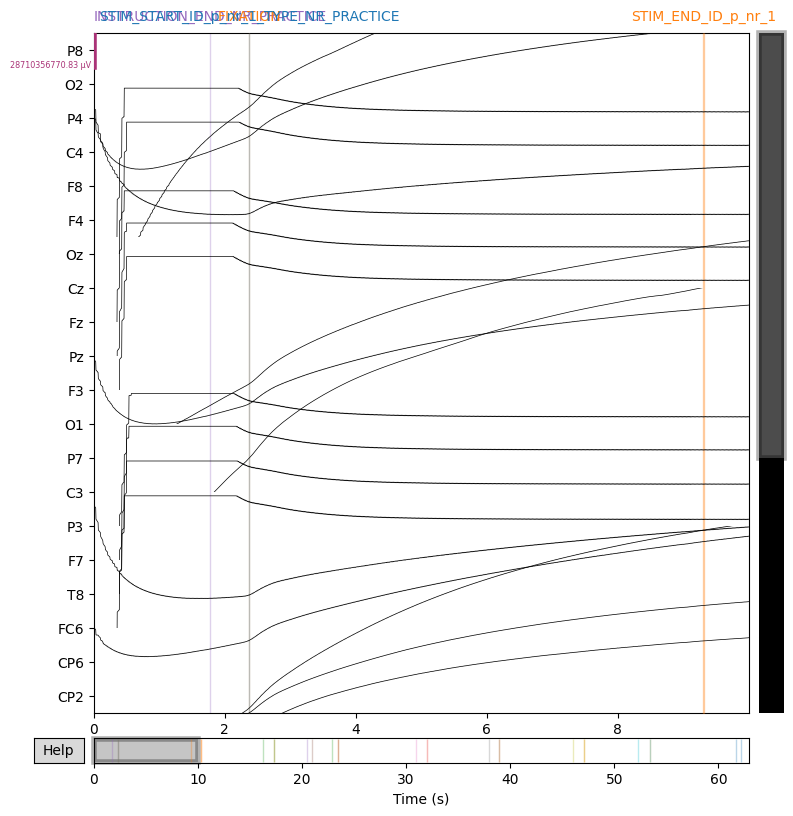

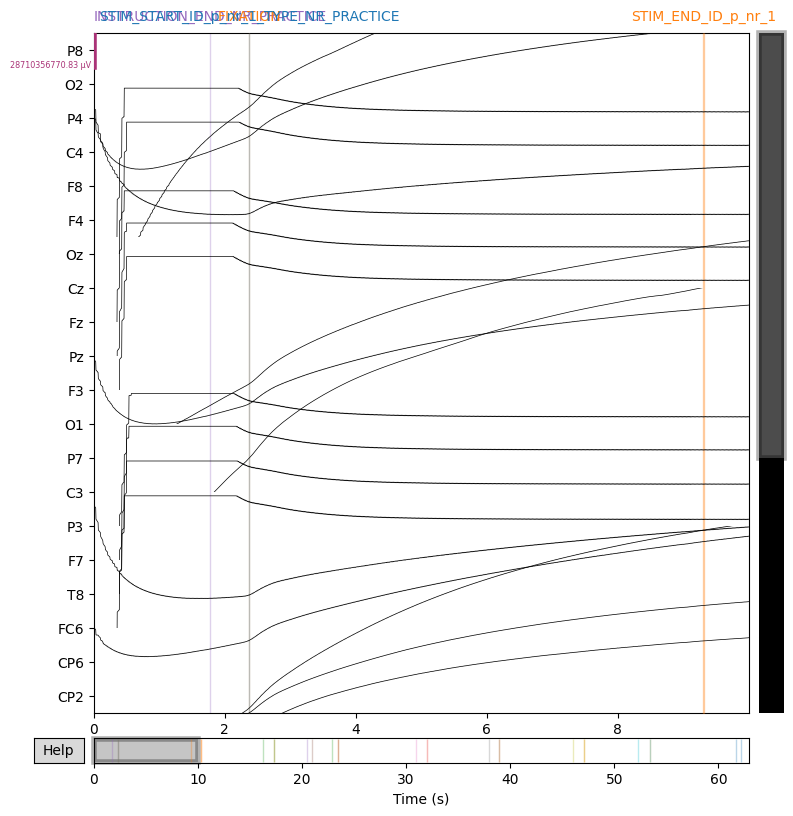

In [28]:
# Interactive plot of RAW data using MNE's built-in viewer
# Using scalings="auto" as recommended by BrainAccess docs
raw_eeg = raw.copy().pick('eeg')

# Plot with auto scaling - MNE will figure out the best scale
# This opens an interactive window where you can scroll through the data
raw_eeg.plot(
    scalings="auto",  # Let MNE auto-scale based on data
    title="Raw EEG Data (unfiltered) - Interactive",
    show=True,
    block=False
)

=== Data after filtering (1-40 Hz) ===
Data range: -63653.583358 to 9693.316841
Mean: -153.038065
Std: 4036.103722


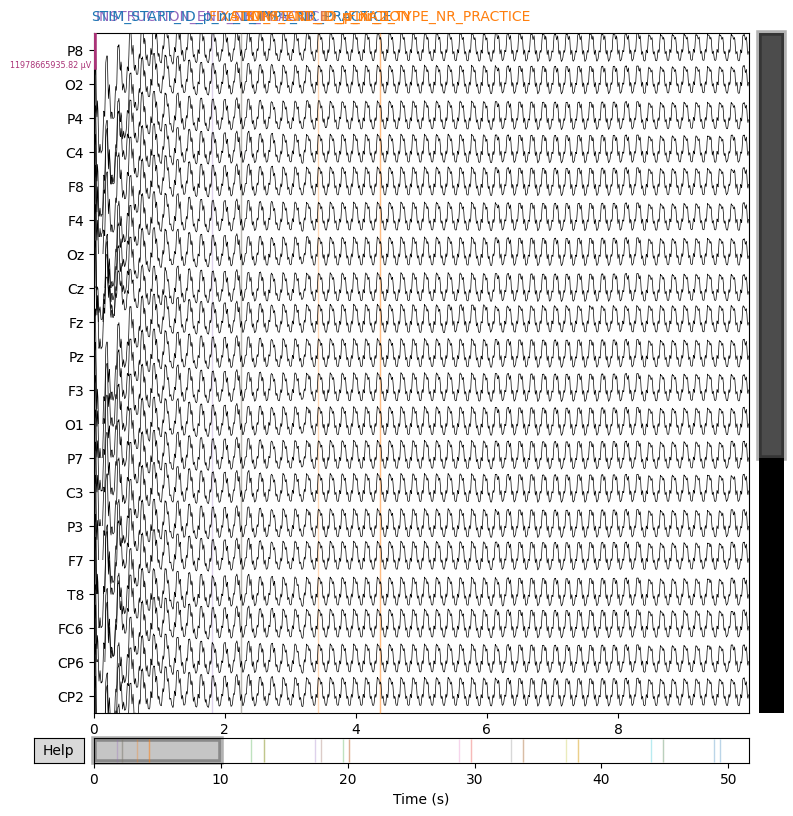

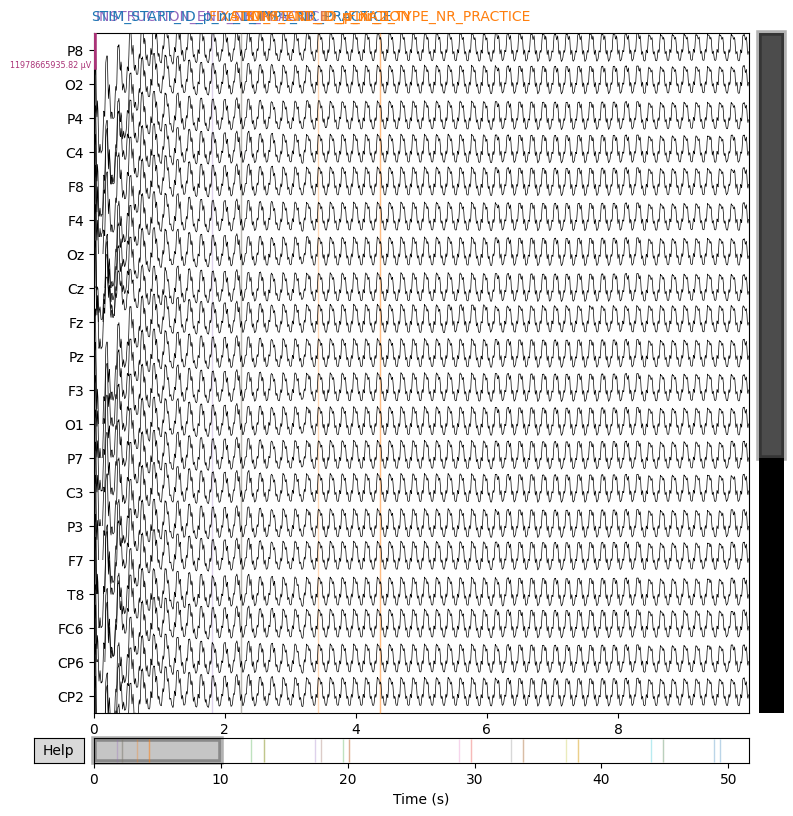

In [17]:
# Apply bandpass filter (1-40 Hz) as recommended by BrainAccess
raw_filtered = raw.copy().pick('eeg')
raw_filtered.filter(l_freq=1, h_freq=40, verbose=False)

print("=== Data after filtering (1-40 Hz) ===")
filtered_data = raw_filtered.get_data()
print(f"Data range: {filtered_data.min():.6f} to {filtered_data.max():.6f}")
print(f"Mean: {filtered_data.mean():.6f}")
print(f"Std: {filtered_data.std():.6f}")

# Interactive plot of filtered data
raw_filtered.plot(
    scalings="auto",
    title="Filtered EEG Data (1-40 Hz) - Interactive",
    show=True,
    block=False
)

/home/grzegina/documents/projects/EEG2Text-Experiment/venv/lib/python3.11/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Text(0.5, 1.0, 'Power Spectral Density (averaged across channels)')

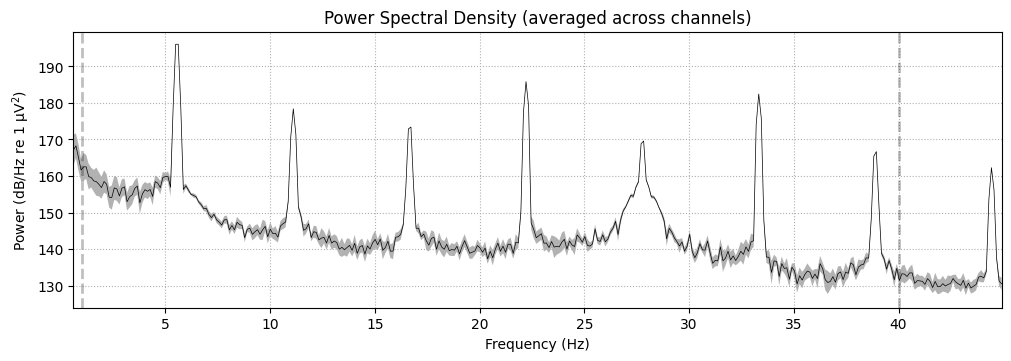

In [19]:
# Plot Power Spectral Density to analyze frequency content
fig = raw_filtered.compute_psd(fmin=0.5, fmax=45).plot(
    average=True,
    show=True
)
plt.title("Power Spectral Density (averaged across channels)")

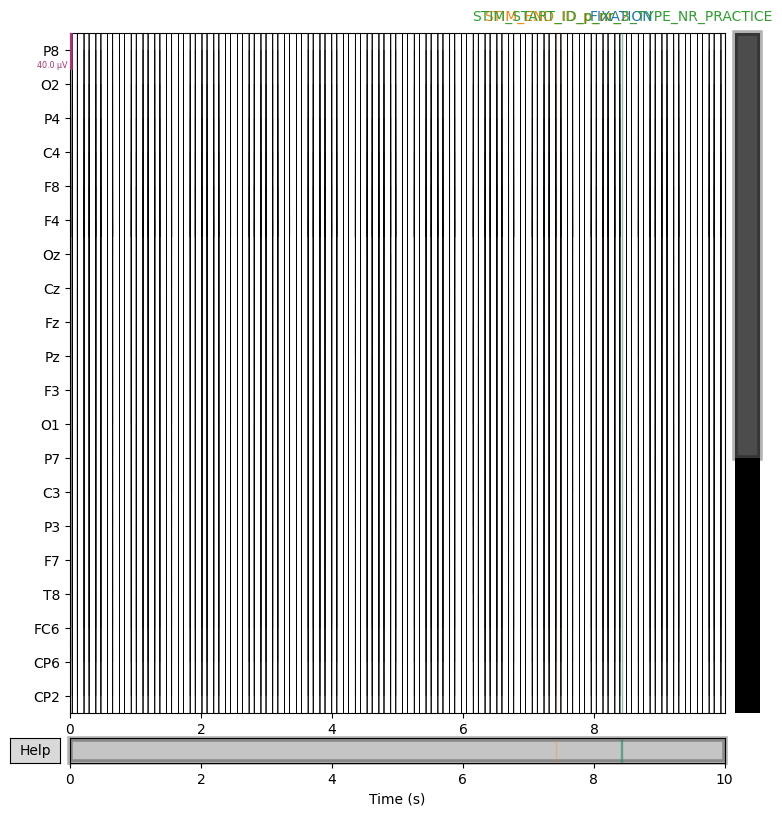

In [ ]:
## Data Quality Assessment

**Issues Found:**
1. **Data units are wrong** - values range from 3,500 to 84,000 instead of proper µV/V units
2. **Strong ~5.5 Hz artifact** with harmonics (11, 16.5, 22, 27.5, 33, 38.5 Hz) - this is NOT brain signal
3. **Channels highly correlated** (0.88-0.99) - suggests common-mode noise or reference issue

**Likely causes:**
- Poor reference electrode contact during recording
- Hardware interference from the BrainAccess device
- The data wasn't saved with proper unit conversion

**Recommendations:**
- Re-record with better electrode contact
- Check impedance before recording
- Verify the BrainAccess saving procedure converts units properly

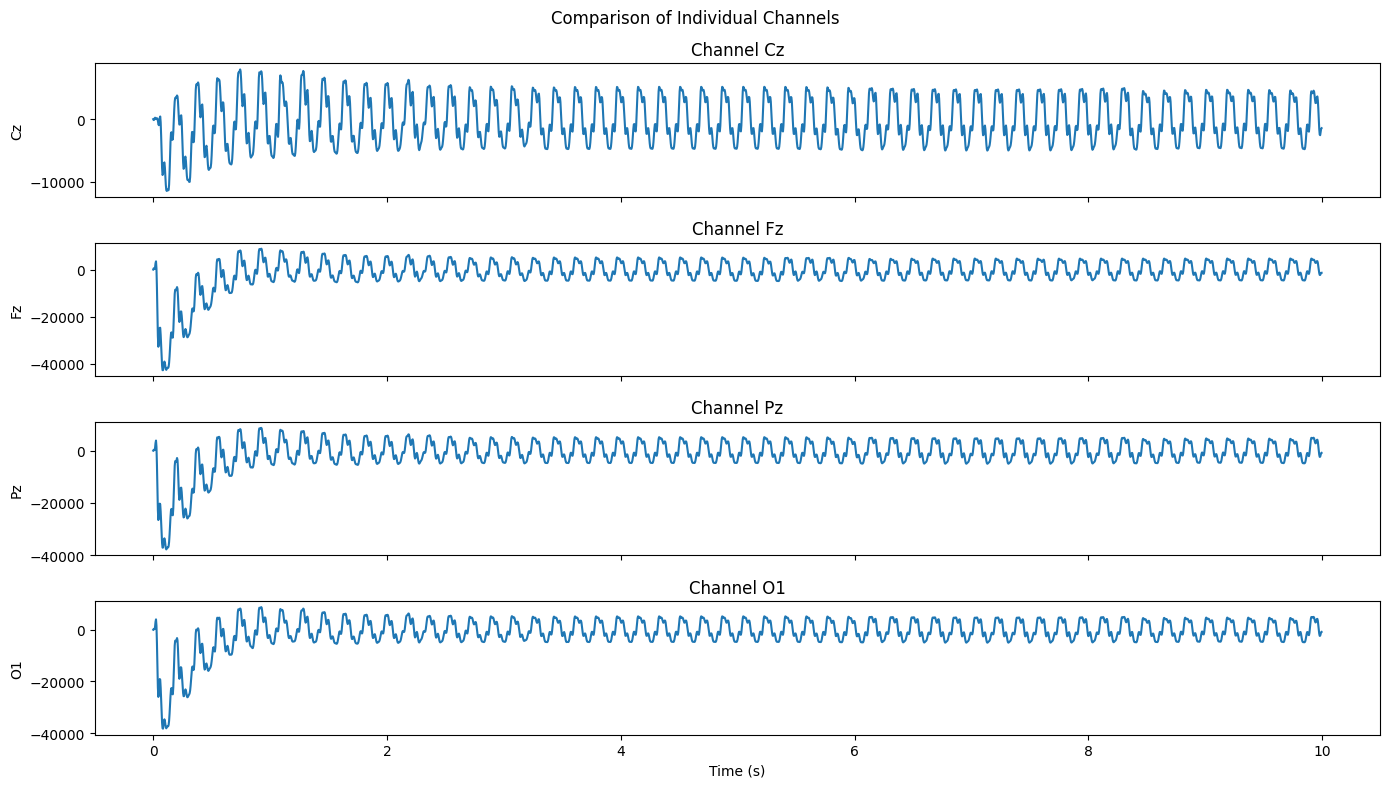


=== Channel Correlation Matrix ===
Correlations between ['Cz', 'Fz', 'Pz', 'O1']:
  Cz vs Fz: 0.8843
  Cz vs Pz: 0.9158
  Cz vs O1: 0.9142
  Fz vs Pz: 0.9968
  Fz vs O1: 0.9970
  Pz vs O1: 0.9997


In [18]:
# Compare a few channels directly to see if they're truly identical
channels_to_compare = ['Cz', 'Fz', 'Pz', 'O1']
data_subset = raw_filtered.copy().pick(channels_to_compare).get_data()

fig, axes = plt.subplots(len(channels_to_compare), 1, figsize=(14, 8), sharex=True)
times = raw_filtered.times[:2500]  # First 10 seconds

for i, ch in enumerate(channels_to_compare):
    axes[i].plot(times, data_subset[i, :2500])
    axes[i].set_ylabel(f'{ch}')
    axes[i].set_title(f'Channel {ch}')

axes[-1].set_xlabel('Time (s)')
plt.suptitle('Comparison of Individual Channels')
plt.tight_layout()
plt.show()

# Check correlation between channels
print("\n=== Channel Correlation Matrix ===")
corr_matrix = np.corrcoef(data_subset)
print(f"Correlations between {channels_to_compare}:")
for i, ch1 in enumerate(channels_to_compare):
    for j, ch2 in enumerate(channels_to_compare):
        if i < j:
            print(f"  {ch1} vs {ch2}: {corr_matrix[i,j]:.4f}")

=== Annotations/Events ===
Number of annotations: 28

First 10 annotations:
  1. onset=1.81s, duration=0.00s, description='INSTRUCTION_END_NR_PRACTICE'
  2. onset=2.24s, duration=0.00s, description='FIXATION'
  3. onset=2.24s, duration=0.00s, description='STIM_START_ID_p_nr_1_TYPE_NR_PRACTICE'
  4. onset=3.42s, duration=0.00s, description='STIM_END_ID_p_nr_1'
  5. onset=4.36s, duration=0.00s, description='FIXATION'
  6. onset=4.36s, duration=0.00s, description='STIM_START_ID_p_nr_2_TYPE_NR_PRACTICE'
  7. onset=12.42s, duration=0.00s, description='STIM_END_ID_p_nr_2'
  8. onset=13.42s, duration=0.00s, description='FIXATION'
  9. onset=13.42s, duration=0.00s, description='STIM_START_ID_p_nr_3_TYPE_NR_PRACTICE'
  10. onset=17.42s, duration=0.00s, description='STIM_END_ID_p_nr_3'


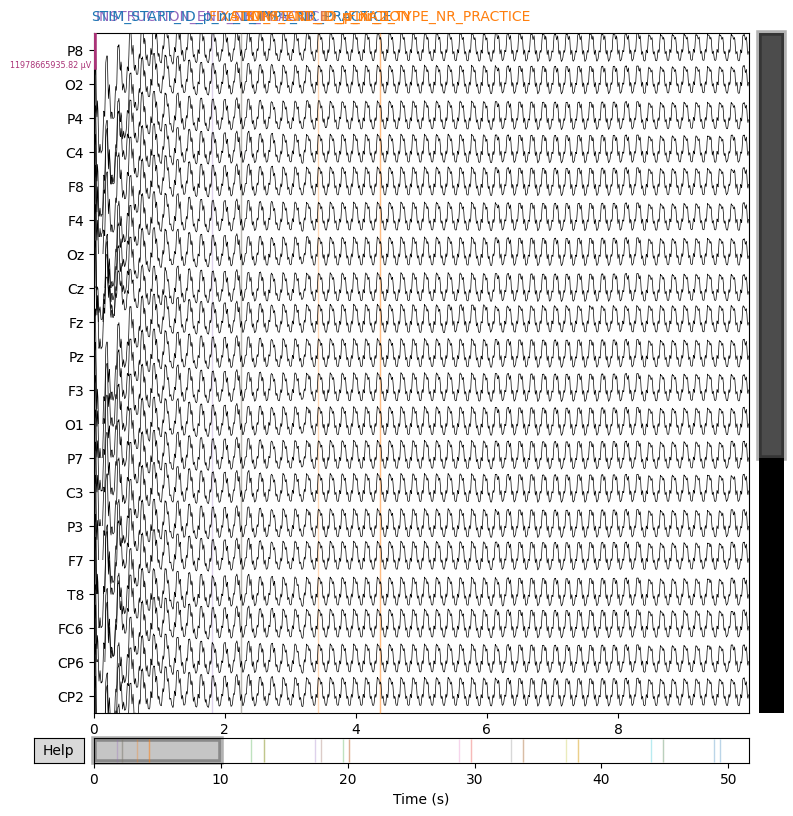

In [20]:
# Check event markers/annotations in the data
print("=== Annotations/Events ===")
print(f"Number of annotations: {len(raw.annotations)}")
if len(raw.annotations) > 0:
    print("\nFirst 10 annotations:")
    for i, ann in enumerate(raw.annotations[:10]):
        print(f"  {i+1}. onset={ann['onset']:.2f}s, duration={ann['duration']:.2f}s, description='{ann['description']}'")
        
# Plot annotations on the data
if len(raw.annotations) > 0:
    raw_filtered.set_annotations(raw.annotations)
    raw_filtered.plot(
        scalings="auto",
        title="Filtered EEG with Event Markers",
        show=True,
        block=False
    )

=== After Common Average Reference ===
Data range: -29380.40 to 31963.16
Std: 900.96


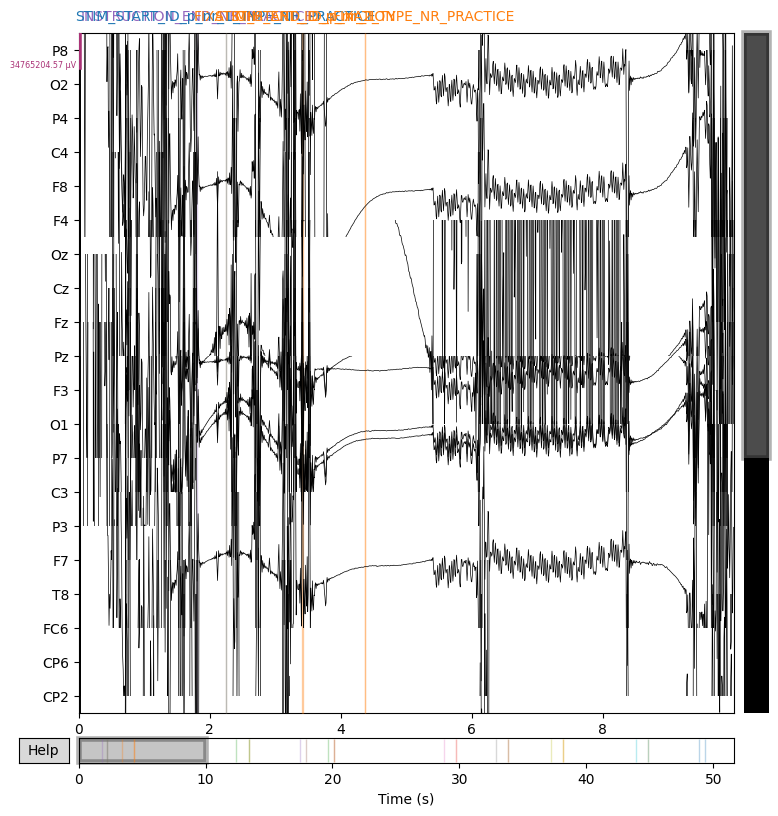

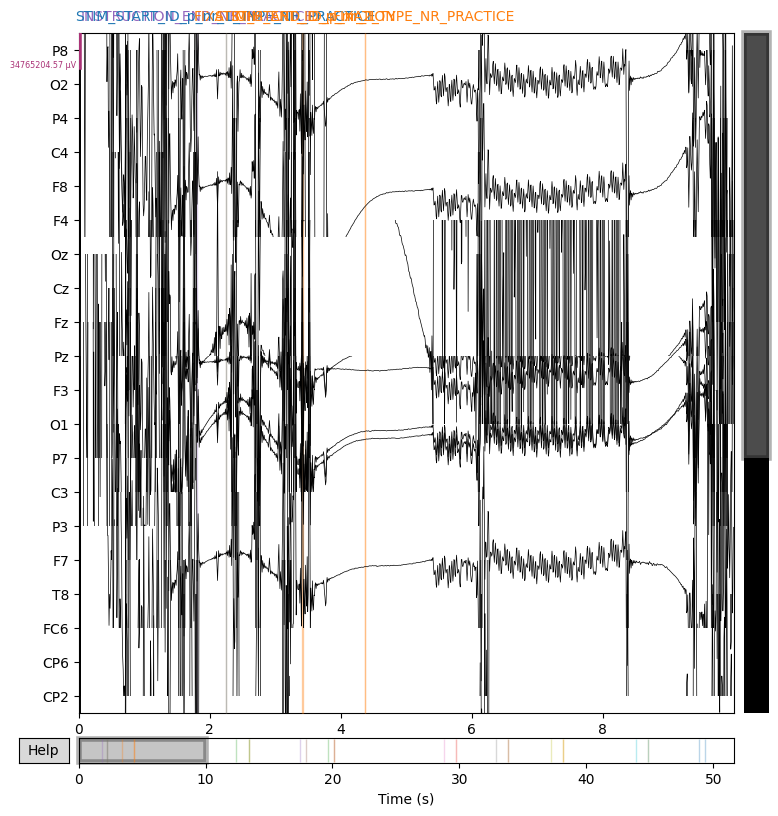

In [21]:
# Try to salvage data by applying common average reference (CAR)
# This can help remove common-mode noise

raw_car = raw_filtered.copy()
raw_car.set_eeg_reference('average', projection=False, verbose=False)

print("=== After Common Average Reference ===")
car_data = raw_car.get_data()
print(f"Data range: {car_data.min():.2f} to {car_data.max():.2f}")
print(f"Std: {car_data.std():.2f}")

# Plot after CAR
raw_car.plot(
    scalings="auto",
    title="EEG after Common Average Reference",
    show=True,
    block=False
)

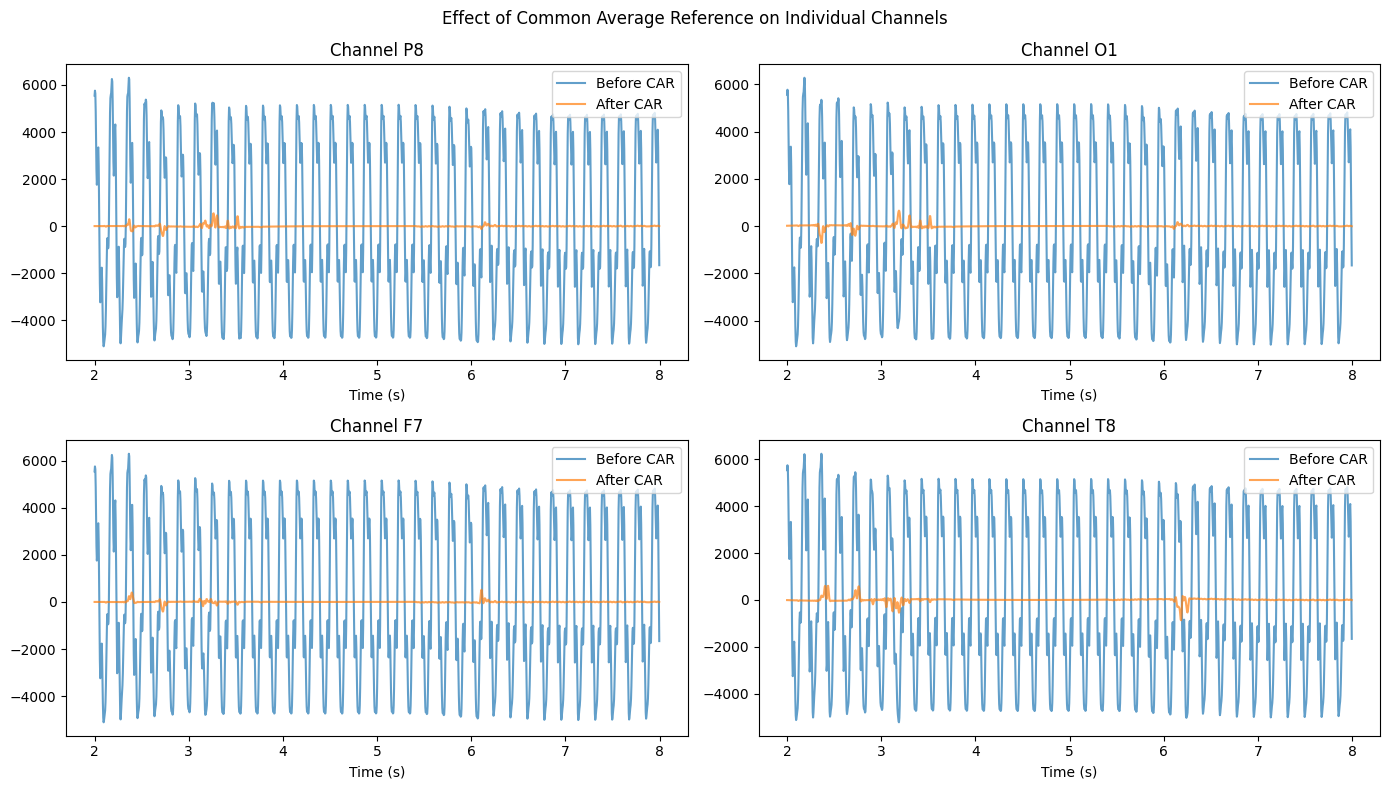


=== SUMMARY ===
The 5 Hz artifact is COMMON MODE noise present in all channels.
After applying Common Average Reference (CAR), channels show different signals.
Several channels appear to have poor/no contact (flat after CAR).
The data quality is compromised - consider re-recording.


In [23]:
# Final summary: Compare before/after CAR for specific channels
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Pick a channel that looked active after CAR
test_channels = ['P8', 'O1', 'F7', 'T8']
times = raw_filtered.times[500:2000]  # 2-8 seconds to skip edge artifacts

for i, ch in enumerate(test_channels):
    ax = axes[i // 2, i % 2]
    
    # Before CAR
    before = raw_filtered.copy().pick([ch]).get_data()[0, 500:2000]
    # After CAR  
    after = raw_car.copy().pick([ch]).get_data()[0, 500:2000]
    
    ax.plot(times, before, label='Before CAR', alpha=0.7)
    ax.plot(times, after, label='After CAR', alpha=0.7)
    ax.set_title(f'Channel {ch}')
    ax.legend()
    ax.set_xlabel('Time (s)')

plt.suptitle('Effect of Common Average Reference on Individual Channels')
plt.tight_layout()
plt.show()

print("\n=== SUMMARY ===")
print("The 5 Hz artifact is COMMON MODE noise present in all channels.")
print("After applying Common Average Reference (CAR), channels show different signals.")
print("Several channels appear to have poor/no contact (flat after CAR).")
print("The data quality is compromised - consider re-recording.")